In [1]:
import skmob
import osmnx as ox

### Loading input files...

- `modelli_auto` contains the vehicles' information from which the `fuel_type` will be extracted;
- `emission_functions` contains the values for the emission functions
- `max_interval` is the maximum time interval (in seconds) that one wants between each pair of points in the trajectories;
- `region` is just the name of the region for which the road network is needed;
- `pollutant_to_plot` is one of `{'CO_2', 'NO_x', 'PM', 'VOC'}`

In [2]:
###### Parameters here:
path_to_table_with_info_on_vehicles = './data/modelli_auto.tar.xz'
path_to_table_with_emission_functions = './data/emission_functions.csv'
max_interval = 120
region = 'Rome'
pollutant_to_plot = 'CO_2' # one of: CO_2, NO_x, PM, VOC
######

#### Option 1: load a little tdf from ./data

- `some_trajectories_in_Rome.json` is a `TrajDataFrame` with a little sample of trajectories of some vehicles moving in the center of Rome;

In [8]:
path_to_input_file = './data/some_trajectories_in_Rome.json'
tdf = skmob.read(path_to_input_file)

print("Num of selected trajectories ('tid'):", len(set(tdf['tid'])))
set_of_uid_in_input = set(tdf['uid'])
num_of_uid_in_input = len(set_of_uid_in_input)
print("Num of vehicles ('uid'):", num_of_uid_in_input)
tdf.drop(['tile_ID'], axis=1).head()  # (dropping column 'tileID', not needed here)

Num of selected trajectories ('tid'): 1087
Num of vehicles ('uid'): 68


,uid,tid,lat,lng,datetime
122384,116559,109,41.889132,12.491207,2017-02-19 16:12:02
122814,116559,203,41.896708,12.487090,2017-04-07 19:26:22
122815,116559,204,41.896708,12.487090,2017-04-08 00:11:12
122816,116559,204,41.897440,12.495395,2017-04-08 00:18:37
122858,116559,214,41.897116,12.484191,2017-04-12 17:00:23


#### Option 2: load a tdf directly from the remote db

- note: change the `path_to_config_file` and `uid_limit`

In [4]:
### or taking data directly from the remote db

import json
import psycopg2
import geopandas as gpd
import pandas as pd
from skmob.tessellation import tilers

# 1. load the json configuration file
path_to_config_file = '/home/matteo/PROJECTS/MOBILITY_ROME/dataset_tak_italy_traj/config.json'
config = json.load(open(path_to_config_file))

# 2. execute the query
print('Executing the query...')
uid_limit = 100
con = psycopg2.connect(database=config['database'], 
                       user=config['user'], 
                       password=config['password'],
                       host=config['host'], 
                       port=config['port'])
sql = "select * from %s where uid in (select distinct uid from %s limit %s);" %(config['table'], 
                                                                                config['table'],
                                                                                uid_limit)
gdf = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='traj')

# 3. create the tdf
print('Creating TrajDataFrame...')
def get_points(row):
    """
    Create a DataFrame from each user and trajectory identifier, 
    extracting latitude, longitude and datetime from each trajectory
    
    Parameters
    ----------
    row: pandas DataFrame
        the DataFrame describing a trajectory for a user
        
    Returns
    -------
    pandas DataFrame
        a DataFrame containing latitude (lat), longitude (lng) and datetime
    """
    rows = []
    for point in row.traj.iloc[0].coords:
        lat, lon = point[1], point[0]
        time = pd.to_datetime(point[2] * 1000, unit='s') # time is UTC time divided by 1000
        rows.append([lat, lon, time])
    return pd.DataFrame(rows, columns=['lat', 'lng', 'datetime'])

dis_gdf = gdf.groupby(['uid','tid']).apply(lambda row: get_points(row)).reset_index().drop('level_2', axis=1).astype({'tid': 'int32'})
tdf_with_all_points = skmob.TrajDataFrame(dis_gdf)
print('Size of TrajDataFrame: %s' %len(tdf_with_all_points))

# 4. Build a tessellation over the city
n_cells = 1000
region_name = region.lower().replace(" ", "_")
tessellation = tilers.tiler.get("squared", base_shape=region, meters=n_cells)

# 5. map tdf over the tessellation, removing points that do not fall within it
print('Mapping the tessellation...')
tdf_mapped = tdf_with_all_points.mapping(tessellation, remove_na=True)

tdf = tdf_mapped.copy()

Executing the query...


KeyError: 'table'

In [ ]:
print("Num of selected trajectories ('tid'):", len(set(tdf['tid'])))
set_of_uid_in_input = set(tdf['uid'])
num_of_uid_in_input = len(set_of_uid_in_input)
print("Num of vehicles ('uid'):", num_of_uid_in_input)
tdf.head()

### Filtering...

#### 1. on time: 
this retains only sub-trajectories composed by points that are distant not more than `max_interval` (in seconds) from each other;

In [5]:
from filtering import *

tdf_filtered_time = filter_on_time_interval(tdf, max_interval)

#### 2. on speed: 
this retains only points that have a value of speed not greater than `max_speed_kmh`;

In [6]:
from skmob.preprocessing import filtering

tdf_filtered_speed = filtering.filter(tdf_filtered_time, max_speed_kmh = 300)

#### 3. on acceleration: 
this retains only points that have a value of acceleration not greater than 10 m/s^2;

In [7]:
from speed_and_acceleration import *

tdf_with_speed_and_acc = compute_acceleration_from_tdf(tdf_filtered_speed)
ftdf = tdf_with_speed_and_acc[tdf_with_speed_and_acc['acceleration'] < 10]

In [8]:
set_of_uid_final = set(ftdf['uid'])
num_of_uid_final = len(set_of_uid_final)
print('There have been', num_of_uid_in_input-num_of_uid_final, "'uid' lost in the filtering process.")
print('Total number of uids:', ftdf.uid.unique().shape[0])
ftdf.head(9)

There have been 57 'uid' lost in the filtering process.
Total number of uids: 11


,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000


### Loading the road network...

In [9]:
''' (This takes a bit longer...)
region_name = region.lower().replace(" ", "_")
road_network = ox.graph_from_place(region, network_type = 'drive_service')
'''

# Taking a little road network centered in Piazza Venezia, Rome:
road_network = ox.graph_from_point((41.895947, 12.483000), distance=1500, network_type = 'drive_service') # Roma (centered on Piazza Venezia)

### Map-matching...

In [10]:
from map_matching import *

ftdf_final = find_nearest_edges_in_network(road_network, ftdf, return_tdf_with_new_col=True)
ftdf_final.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[1107548553, 25419843]"
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[1107548553, 25419843]"
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144912, 246144858]"
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144912, 246144858]"
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[246142109, 25418929]"
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[246142109, 25418929]"
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[246142109, 25418929]"
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[246142109, 25418929]"
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[269277049, 32650405]"


### Computing emissions...

- loading information on fuel types and emission functions:

In [11]:
from emissions import *
import tarfile

tar = tarfile.open(path_to_table_with_info_on_vehicles, "r:xz")
for x in tar.getmembers():
    file = tar.extractfile(x)
    modelli_auto = pd.read_csv(file, names=['vid', 'manufacturer', 'type'], usecols = [0,1,2])

modelli_auto.head()

,vid,manufacturer,type
0,1,PEUGEOT,106 106 954I CAT 3 PORTE XN
1,2,FIAT,SEICENTO SEICENTO
2,3,FIAT,SEICENTO SEICENTO
3,4,MINI,MINI COUNTRYMAN R60 MINI 2.0 COOPER D COUNTRYM...
4,5,FIAT,SEICENTO SEICENTO 1.1I CAT SPORTING


In [12]:
emissions = pd.read_csv(path_to_table_with_emission_functions)

- from modelli_auto, selecting only the vehicles that are in our filtered tdf:

In [13]:
df_vehicles_info = modelli_auto.loc[modelli_auto['vid'].isin(set_of_uid_final)]

- matching each of the selected vehicle with its fuel type:

In [14]:
dict_vehicle_fuel_type = match_vehicle_to_fuel_type(ftdf_final, modelli_auto, ['PETROL', 'DIESEL', 'LPG'])

- finally computing emissions:

In [15]:
tdf_with_emissions = compute_emissions(ftdf_final, emissions, dict_vehicle_fuel_type)
tdf_with_emissions.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link,CO_2,NO_x,VOC,PM
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[1107548553, 25419843]",0.553000,0.000619,0.00447,0.000000
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[1107548553, 25419843]",0.553000,0.000619,0.00447,0.000000
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144912, 246144858]",0.553000,0.000619,0.00447,0.000000
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144912, 246144858]",0.553000,0.000619,0.00447,0.000000
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[246142109, 25418929]",0.553000,0.000619,0.00447,0.000000
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[246142109, 25418929]",0.553000,0.000619,0.00447,0.000000
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[246142109, 25418929]",0.571873,0.000627,0.00447,0.000002
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[246142109, 25418929]",0.592178,0.000636,0.00447,0.000004
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[269277049, 32650405]",0.553000,0.000619,0.00447,0.000000


### Plotting results...

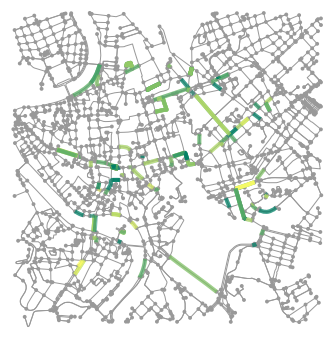

In [25]:
from plot import *

fig, ax = plot_road_network_with_emissions(tdf_with_emissions, road_network, 
                                           name_of_pollutant = pollutant_to_plot, save_fig=False)